# Step 3. Feature Engineering
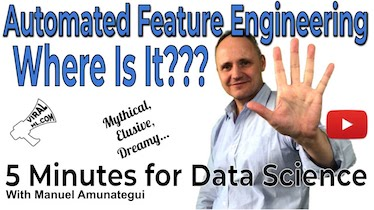

## TODO:
- try bigger window for derivatives to avoid overfit

## Import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 150)
from colorama import Fore
from ipywidgets import interact, widgets
from sklearn.preprocessing import LabelEncoder

from utility import plot_timeseries, plot_derivatives

Load data from previous step:

In [ ]:
datamart = pd.read_feather('./datasets/datamart_cleaned.feather')
datamart.info(memory_usage='deep', null_counts=True)

Filter datamart:

In [ ]:
#datamart = datamart[(datamart.site_id == 2) | (datamart.site_id == 3)]
#datamart.info(memory_usage='deep')

## Add features
#### 1. Time features.

In [ ]:
def add_time_features(datamart, time_col='timestamp'):
    """Add time features to datamart."""
    datamart['hour'] = np.uint8(datamart[time_col].dt.hour)
    datamart['day_of_week'] = np.uint8(datamart[time_col].dt.dayofweek + 1)
    datamart['day_of_month'] = np.uint8(datamart[time_col].dt.day)
    datamart['day_of_year'] = np.uint16(datamart[time_col].dt.dayofyear)
    datamart['week_of_year'] = np.uint8(datamart[time_col].dt.week)
    datamart['month'] = np.uint8(datamart[time_col].dt.month)
    datamart['year'] = np.uint16(datamart[time_col].dt.year)
    
    features = ['hour', 'day_of_week', 'day_of_month', 'day_of_year', 
                'week_of_year', 'month', 'year']
    return datamart, features

datamart, time_features = add_time_features(datamart)

In [ ]:
#datamart.info(memory_usage='deep')
#display(datamart[['timestamp'] + time_features].head(50))
#display(datamart[['timestamp'] + time_features].tail(50))

#### 2. Weather features.

#### 2.1. Air temperature.

Plot temperature by site:

In [ ]:
def plot_temperature_by_site(datamart, cols=['air_temperature', 'air_temperature_filled']):
    """Plot temperature with interactive site selection."""
    datamart = datamart.groupby(['site_id', 'timestamp'])[cols].mean().reset_index()
    datamart = datamart.fillna(-100)
    
    def plot_site_temp(site_id):
        df_to_plot = datamart[datamart['site_id'] == site_id].set_index('timestamp')[cols]
        plot = df_to_plot.iplot(
            asFigure=True, kind='scatter', width=1, theme='ggplot',
            dimensions=(None, None), margin=(0, 0, 30, 30)
        )
        display(plot)
    
    
    interact(plot_site_temp, site_id=datamart['site_id'].drop_duplicates())
    
datamart['air_temperature_filled'] = datamart['air_temperature']
#plot_temperature_by_site(datamart)

Fill missing temperature values:

In [7]:
datamart.sort_values(by=['meter', 'building_id', 'timestamp'], inplace=True)
#datamart['air_temperature_filled'] = datamart.groupby(['meter', 'building_id'])['air_temperature']\
#    .fillna(method='ffill').fillna(method='bfill').values
datamart['air_temperature_filled'] = datamart.groupby(['meter', 'building_id'])['air_temperature']\
    .apply(lambda group: group.interpolate(method='linear', limit_direction='both')).values

Check if all missing values are filled:

In [8]:
missing_values = datamart['air_temperature_filled'].isna().sum()
print(f'Count of missing values = {missing_values}')

Count of missing values = 0


In [9]:
plot_temperature_by_site(datamart)

interactive(children=(Dropdown(description='site_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

In [10]:
datamart['air_temperature'] = datamart['air_temperature_filled']
datamart.drop('air_temperature_filled', axis=1, inplace=True)

#### 2.2. Cloud coverage.

In [11]:
def plot_cloud_coverage_by_site(datamart, cols=['cloud_coverage', 'cloud_coverage_filled']):
    """Plot temperature with interactive site selection."""
    datamart = datamart.groupby(['site_id', 'timestamp'])[cols].mean().reset_index()
    datamart = datamart.fillna(-20)
    
    def plot_site_cloud_coverage(site_id):
        df_to_plot = datamart[datamart['site_id'] == site_id].set_index('timestamp')[cols]
        plot = df_to_plot.iplot(
            asFigure=True, kind='scatter', width=1, theme='ggplot',
            dimensions=(None, None), margin=(0, 0, 30, 30)
        )
        display(plot)
    
    
    interact(plot_site_cloud_coverage, site_id=datamart['site_id'].drop_duplicates())
    
datamart['cloud_coverage_filled'] = datamart['cloud_coverage']
#plot_cloud_coverage_by_site(datamart)

Fill missing cloud coverage values:

In [12]:
datamart.sort_values(by=['meter', 'building_id', 'timestamp'], inplace=True)
datamart['cloud_coverage_filled'] = datamart.groupby(['meter', 'building_id'])['cloud_coverage']\
    .fillna(method='ffill').fillna(method='bfill').values

Check if all missing values are filled:

In [13]:
missing_values = datamart['cloud_coverage_filled'].isna().sum()
print(f'Count of missing values = {missing_values}')

Count of missing values = 0


In [14]:
plot_cloud_coverage_by_site(datamart)

interactive(children=(Dropdown(description='site_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

In [15]:
datamart['cloud_coverage'] = datamart['cloud_coverage_filled'].astype(np.uint8)
datamart.drop('cloud_coverage_filled', axis=1, inplace=True)

#### 3. Encode categorical features.

In [16]:
le = LabelEncoder()
datamart['primary_use'] = le.fit_transform(datamart['primary_use']).astype(np.uint8)

#### 4. Transform target.

Apply log transform to target:

In [17]:
datamart['fact_log'] = np.log1p(datamart['fact'])
datamart['leak_log'] = np.log1p(datamart['leak'])
datamart['target_log'] = np.log1p(datamart['target'])

C:\Programs\Anaconda\lib\site-packages\pandas\core\series.py:853: RuntimeWarning:

invalid value encountered in log1p



Supress target to float32:

In [18]:
#for col in ['fact', 'fact_log', 'leak', 'leak_log', 'target', 'target_log']:
#    datamart[col] = datamart[col].astype(np.float32)

#### 5. Derivatives of target.

In [19]:
#datamart = datamart[((datamart['building_id'] == 156) | (datamart['building_id'] == 419) | \
#                     (datamart['building_id'] == 420) | (datamart['building_id'] == 564)) & (datamart['meter'] == 0)]

In [ ]:
# Better way:
#df = pd.DataFrame({'a': [0, 0, 1, 1], 'b': [1, 2, 3, 4]})
#df['lag_mean'] = df.groupby('a')['b'].rolling(window=2, min_periods=1).mean()\
#    .groupby('a').shift(1).reset_index(drop=True)
# Also concat is better than append

In [ ]:
def create_lag_features(df, window):
    """
    Creating lag-based features looking back in time.
    """
    
    feature_cols = ["air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"]
    df_site = df.groupby("site_id")
    
    df_rolled = df_site[feature_cols].rolling(window=window, min_periods=0)
    
    df_mean = df_rolled.mean().reset_index().astype(np.float16)
    df_median = df_rolled.median().reset_index().astype(np.float16)
    df_min = df_rolled.min().reset_index().astype(np.float16)
    df_max = df_rolled.max().reset_index().astype(np.float16)
    df_std = df_rolled.std().reset_index().astype(np.float16)
    df_skew = df_rolled.skew().reset_index().astype(np.float16)
    
    for feature in feature_cols:
        df[f"{feature}_mean_lag{window}"] = df_mean[feature]
        df[f"{feature}_median_lag{window}"] = df_median[feature]
        df[f"{feature}_min_lag{window}"] = df_min[feature]
        df[f"{feature}_max_lag{window}"] = df_max[feature]
        df[f"{feature}_std_lag{window}"] = df_std[feature]
        df[f"{feature}_skew_lag{window}"] = df_std[feature]
        
    return df

In [20]:
%%time
def smart_shift(datamart, group_cols, target_col, lag):
    #datamart[datamart.isna()] = datamart.shift(lag)
    #datamart[datamart.isna()] = datamart.shift(lag)
    datamart = datamart.shift(lag)
    return datamart
    
def generate_derivatives(datamart, group_cols, target_col, window, lag, center, prefix='q'):  
    """Add target derivatives to datamart."""
    values = datamart[group_cols + [target_col]]
    grouped = values.groupby(group_cols).rolling(window=window, center=center, min_periods=int(window/2))
        
    q_mean = grouped.mean().rename(columns={target_col: f'{prefix}_mean'})
    q_std = grouped.std().rename(columns={target_col: f'{prefix}_std'})
    q_05 = grouped.quantile(0.05, interpolation='lower').rename(columns={target_col: f'{prefix}_05'})
    q_50 = grouped.quantile(0.50, interpolation='lower').rename(columns={target_col: f'{prefix}_50'})
    q_95 = grouped.quantile(0.95, interpolation='lower').rename(columns={target_col: f'{prefix}_95'})
    for derivative in [q_mean, q_std, q_05, q_50, q_95]:
        col = derivative.columns[-1]
        derivative[col] = derivative[col].astype(np.float32)
        print(col)
        #derivative = derivative.drop(group_cols, axis=1).groupby(group_cols).shift(lag)\
        #    .reset_index().set_index(f'level_{len(group_cols)}').drop(group_cols, axis=1)
        derivative = derivative.drop(group_cols, axis=1).groupby(group_cols)\
            .apply(smart_shift, group_cols=group_cols, target_col=target_col, lag=lag)\
            .reset_index().set_index(f'level_{len(group_cols)}').drop(group_cols, axis=1)
        datamart = datamart.merge(derivative, how='left', left_index=True, right_index=True)
    features = [f'{prefix}_mean', f'{prefix}_std', f'{prefix}_05', 
                f'{prefix}_50', f'{prefix}_95']
    
    return datamart, features

datamart, seasonal_features = generate_derivatives(
    datamart, group_cols=['meter', 'building_id'], target_col='target_log',
    window=2*28*24, lag=365*24, center=True, prefix='s',
)
datamart, trend_features = generate_derivatives(
    datamart, group_cols=['meter', 'building_id'], target_col='target_log',
    window=2*28*24, lag=6*28*24, center=True, prefix='t',
)

s_mean
s_std
s_05
s_50
s_95
t_mean
t_std
t_05
t_50
t_95
Wall time: 37min 54s


In [21]:
#datamart['air_temperature_filled'] = datamart.groupby(['meter', 'building_id'])['air_temperature']\
#    .apply(lambda group: group.interpolate(method='linear', limit=24*28, limit_direction='both')).values

In [22]:
plot_derivatives(datamart, target_col='target_log', derivatives_cols=seasonal_features+trend_features)

interactive(children=(RadioButtons(description='meter', options=(('Electricity (0)', 0), ('Chilled water (1)',…

In [23]:
#datamart2 = pd.read_feather('./datasets/datamart_features.feather')

In [24]:
#plot_derivatives(datamart2, target_col='target_log', derivatives_cols=derivatives_features)

In [25]:
#test = pd.DataFrame({'group_id':[0, 0, 0, 0, 1, 1, 1, 1], 'value':[2, 3, np.nan, np.nan, 4, 5, np.nan, np.nan]})
#display(test.groupby('group_id').rolling(1, min_periods=0).mean().drop('group_id', axis=1)\
#        .groupby('group_id').shift(3))
#display(test.rolling(2, min_periods=0).quantile(0.5, interpolation='lower').shift(2))
#test.shift(2)

In [26]:
#datamart.info(memory_usage='deep', null_counts=True)

## Final steps

In [27]:
#plot_timeseries(datamart, use_log_values=True)

Final list of columns:

In [28]:
cols = [
    'meter', 'site_id', 'building_id', 'timestamp', 
    'row_id', 'primary_use', 'square_feet', 'air_temperature', 'cloud_coverage',
] + time_features + seasonal_features + trend_features + [
    #'fact', 'fact_log',
    'leak', 'leak_log', 'target', 'target_log']
datamart = datamart[cols]

Check for duplicates:

In [29]:
assert datamart[['meter', 'building_id', 'timestamp']].duplicated().sum() == 0, 'Duplicates found!'

## Save results
Export to feather:

In [30]:
datamart.to_feather('./datasets/datamart_features.feather')

## Notes